### Main imports and GPU settings

In [95]:
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
import torchmetrics

In [96]:
# Show all available GPUs
# print(torch.cuda.get_device_name(0))

# Set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

print('=======================\n')
GPU = False
# Set default tensor type to cuda.FloatTensor if GPU is available
if torch.cuda.is_available() and GPU:
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    torch.set_default_device(device)
    torch.set_default_dtype(torch.float32)
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Dtype: {torch.get_default_dtype()}")
    print(f"Device: {torch.cuda.current_device()}")
else:
    torch.set_default_tensor_type(torch.FloatTensor)
    device = torch.device("cpu")
    torch.set_default_device(device)
    print("Using CPU")


# Set seed for reproducibility
torch.manual_seed(0)

torch.autograd.set_detect_anomaly(True)


cpu

Using CPU


### Local imports of classes

In [97]:
import classes
import systems

# Reload modules
import importlib
importlib.reload(classes)
importlib.reload(systems)

# Local imports modules
from classes import PID
from systems import Trolley

Build Neural Network

In [98]:
# Defining the architecture of the neural network
class PIDNN(nn.Module):
    def __init__(self):
        super(PIDNN, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 3)

        # Normalization
        self.norm = nn.functional.normalize

        # Activation functions
        self.act_tahn = nn.Tanh()
        self.act_relu = nn.ReLU()

        # Initialize weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

        # Initialize biases
        self.fc1.bias.data.fill_(0.1)
        self.fc2.bias.data.fill_(0.1)

    def forward(self, x) -> Tensor:
        x = self.norm(x, dim=0, p=2)
        x = self.fc1(x)
        x = self.act_relu(x)
        x = self.fc2(x)
        x = self.act_tahn(x)
        return x
    

class SystemNN(nn.Module):
    def __init__(self):
        super(SystemNN, self).__init__()
        self.fc1 = nn.Linear(1, 6)
        self.fc2 = nn.Linear(6, 1)

        # Normalization
        self.norm = nn.functional.normalize

        # Activation functions
        self.act_tahn = nn.Tanh()
        self.act_relu = nn.ReLU()

        # Initialize weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

        # Initialize biases
        self.fc1.bias.data.fill_(0.1)
        self.fc2.bias.data.fill_(0.1)

    def forward(self, x) -> Tensor:
        x = self.norm(x, dim=0, p=2)
        x = self.fc1(x)
        x = self.act_relu(x)
        x = self.fc2(x)
        x = self.act_tahn(x)
        return x


# Custom Loss Function
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, E: Tensor) -> Tensor:
        """
        Args:
            vector_K (tensor): [Kp_t, Kp_t_1, Ki_t, Ki_t_1, Kd_t, Kd_t_1] vector of the gains
            vector_E (tensor): [E_t, E_t_1] vector of the errors
            dt (float): time step between the current and previous position

        Returns:
            loss (tensor): loss function
        """
        return E.abs()

### Creating the model, loss function and optimizer

In [99]:
# Model
pidnn = PIDNN()
systemnn = SystemNN()

# Loss function
custom_loss = CustomLoss()

# Optimizers
optimizer_pid = optim.Adam(pidnn.parameters(), lr=0.0013)
# optimizer_sys = optim.Adam(systemnn.parameters(), lr=0.0015)
optimizer_sys = optim.SGD(systemnn.parameters(), lr=0.002)

# Trolley simulation

In [100]:
DT = torch.tensor(0.04)
TIME = torch.arange(0, 100, DT)
DISTURBANCE = torch.zeros_like(TIME)
TARGET = torch.ones_like(TIME) * 10
TARGET[TIME > 70] = 20
TARGET[TIME > 140] = 0
TARGET[TIME > 230] = 10

# Create a system
MASS = torch.tensor(3)
SPRING = torch.tensor(1)
FRICTION = torch.tensor(0.4)
system = Trolley(MASS, SPRING, FRICTION, DT)

In [101]:
# Create a PID controller
KP = torch.tensor(0.7)
KI = torch.tensor(0.1)
KD = torch.tensor(0.1)
pid = PID(KP, KI, KD)
pid.set_limits(
    torch.tensor(100.),
    torch.tensor(-100.),
)

In [102]:
# Loss
feedback_L_pid = torch.zeros(len(TIME))
feedback_L_sys = torch.zeros(len(TIME))
feedback_E_pid = torch.zeros(len(TIME))
feedback_E_sys = torch.zeros(len(TIME))

# Gains
feedback_Kp = torch.zeros(len(TIME))
feedback_Ki = torch.zeros(len(TIME))
feedback_Kd = torch.zeros(len(TIME))

# Systema
feedback_Y = torch.zeros(len(TIME))
feedback_U = torch.zeros(len(TIME))

### Run teaching

In [105]:
def run():
    probress_bar = tqdm(range(len(TIME)))

    Y_ = torch.tensor(0.)
    for i in probress_bar:
        W = TARGET[i]
        D = DISTURBANCE[i]
        Y = system.get_position().detach()
        E = W - Y_

        # Predict
        KKK = pidnn(torch.tensor([W, Y]))
        Kp, Ki, Kd = KKK * 10
        pid.update_gains(Kp, Ki, Kd)    
        U = pid.compute2(E, DT)

        # Store values
        feedback_Y[i] = Y
        feedback_U[i] = U
        feedback_E_pid[i] = E

        # Apply control
        system.apply_control(U)
        Y = system.get_position()
        
        Y_ = systemnn(torch.tensor([U])) * 100
        optimizer_sys.zero_grad()
        loss_sys = (Y_ - Y).pow(2)
        loss_sys.backward(retain_graph=True)
        feedback_E_sys[i] = (Y_ - Y)
        feedback_L_sys[i] = loss_sys

        # Loss and backward pass
        optimizer_pid.zero_grad()
        loss_pid = (W - Y_).pow(2)
        loss_pid.backward()
        feedback_L_pid[i] = loss_pid
        optimizer_pid.step()
    
        with torch.no_grad():
            probress_bar.set_postfix_str(
                f"L_pid: {round(loss_pid.item(), 2)}, L_sys: {round(loss_sys.item(), 2)}"
                f"Kp: {round(Kp.item(), 2)}, Ki: {round(Ki.item(), 2)}, Kd: {round(Kd.item(), 2)}"
                )
            feedback_Kp[i] = Kp
            feedback_Ki[i] = Ki
            feedback_Kd[i] = Kd

    return pidnn

model = run()

  0%|          | 0/2501 [00:00<?, ?it/s]

RuntimeError: output with shape [] doesn't match the broadcast shape [1]

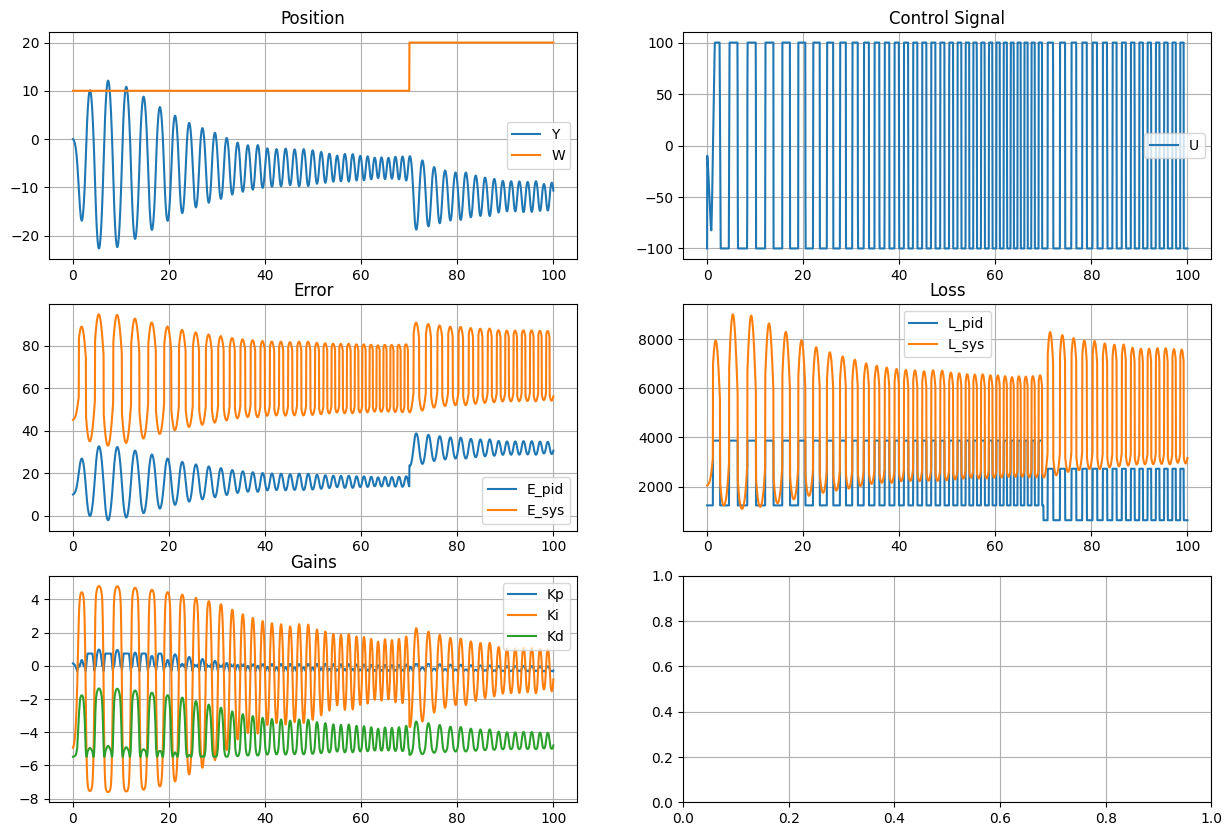

In [ ]:
def plot():
    Y = [x.detach().numpy() for x in feedback_Y]
    W = [x.detach().numpy() for x in TARGET]
    U = [x.detach().numpy() for x in feedback_U]
    E_pid = [x.detach().numpy() for x in feedback_E_pid]
    E_sys = [x.detach().numpy() for x in feedback_E_sys]
    L_pid = [x.detach().numpy() for x in feedback_L_pid]
    L_sys = [x.detach().numpy() for x in feedback_L_sys]

    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    axs[0, 0].plot(TIME, Y, label='Y')
    axs[0, 0].plot(TIME, W, label='W')
    axs[0, 0].set_title('Position')
    axs[0, 0].legend()

    axs[0, 1].plot(TIME, U, label='U')
    axs[0, 1].set_title('Control Signal')
    axs[0, 1].legend()

    axs[1, 0].plot(TIME, E_pid, label='E_pid')
    axs[1, 0].plot(TIME, E_sys, label='E_sys')
    axs[1, 0].set_title('Error')
    axs[1, 0].legend()

    axs[1, 1].plot(TIME, L_pid, label='L_pid')
    axs[1, 1].plot(TIME, L_sys, label='L_sys')
    axs[1, 1].set_title('Loss')
    axs[1, 1].legend()

    axs[2, 0].plot(TIME, feedback_Kp, label='Kp')
    axs[2, 0].plot(TIME, feedback_Ki, label='Ki')
    axs[2, 0].plot(TIME, feedback_Kd, label='Kd')
    axs[2, 0].set_title('Gains')
    axs[2, 0].legend()

    # grid
    for ax in axs.flat:
        ax.grid(True)

plot()